In [ ]:
# Install required packages and gsutil for Google Cloud Storage access
!pip install -q google-cloud-storage
!curl https://sdk.cloud.google.com | bash > /dev/null 2>&1
!gcloud init --console-only < /dev/null  # Authenticate manually in Colab

# Import libraries
import pandas as pd
import numpy as np
import os

# Create directories in Colab local storage
os.makedirs('/content/clusterdata-2019/task_events', exist_ok=True)

# Download a subset of files from the correct bucket (e.g., clusterdata_2019_a)
# We'll download the first shard of instance_events (equivalent to task_events in 2011)
!gsutil cp gs://clusterdata_2019_a/instance_events-000000000000.json.gz /content/clusterdata-2019/task_events/

# Decompress the file
!gunzip /content/clusterdata-2019/task_events/instance_events-000000000000.json.gz

# Check the size of the decompressed file
!ls -lh /content/clusterdata-2019/task_events/instance_events-000000000000.json

# Inspect the first few rows to confirm the schema
part_path = '/content/clusterdata-2019/task_events/instance_events-000000000000.json'
chunk = pd.read_json(part_path, lines=True, nrows=5)
print("First 5 rows of instance_events-000000000000.json:")
print(chunk)
print("\nNumber of columns:", len(chunk.columns))
print("\nColumn names:", chunk.columns.tolist())
print("\nData types:")
print(chunk.dtypes)

# Count the number of rows in the part
row_count = sum(1 for _ in open(part_path))
print(f"\nTotal rows in instance_events-000000000000.json: {row_count}")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   443  100   443    0     0   3065      0 --:--:-- --:--:-- --:--:--  3076
Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  
Copying gs://clusterdata_2019_a/instance_events-000000000000.json.gz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][443.6 MiB/443.6 MiB]   29.2 MiB/s            

In [ ]:
import pandas as pd
import numpy as np

part_path = '/content/clusterdata-2019/task_events/instance_events-000000000000.json'
chunk_size = 1000000
submission_events = []

for chunk in pd.read_json(part_path, lines=True, chunksize=chunk_size):
    submission_chunk = chunk[chunk['type'] == 0].copy()
    submission_chunk['cpu_request'] = submission_chunk['resource_request'].apply(lambda x: x.get('cpus', 0) if isinstance(x, dict) else 0)
    submission_chunk['memory_request'] = submission_chunk['resource_request'].apply(lambda x: x.get('memory', 0) if isinstance(x, dict) else 0)
    submission_events.append(submission_chunk)

task_events = pd.concat(submission_events, ignore_index=True)
print(f"Rows after filtering type == 0: {len(task_events)}")

task_sample = task_events.sample(n=10000, random_state=42).reset_index(drop=True)

df = pd.DataFrame({
    'cpu_load_units': task_sample['cpu_request'].fillna(0) * 10,
    'data_size_MB': task_sample['memory_request'].fillna(0) * 5,
    'deadline_s': task_sample['scheduling_class'].apply(
        lambda x: np.random.uniform(5, 10) if x == 3 else
                  np.random.uniform(10, 15) if x == 2 else
                  np.random.uniform(15, 20))
})

df['cpu_load_units'] = df['cpu_load_units'].clip(1, 10)
df['data_size_MB'] = df['data_size_MB'].clip(1, 5)
df['deadline_s'] = df['deadline_s'].clip(5, 20)

df['task_type'] = np.random.choice(['sensor', 'video', 'analytics'], size=len(df), p=[0.6, 0.2, 0.2])
df.loc[df['task_type'] == 'sensor', 'cpu_load_units'] *= 0.5
df.loc[df['task_type'] == 'video', 'data_size_MB'] *= 1.5
df.loc[df['task_type'] == 'analytics', 'deadline_s'] *= 0.8
df['cpu_load_units'] = df['cpu_load_units'].clip(1, 10)
df['data_size_MB'] = df['data_size_MB'].clip(1, 5)
df['deadline_s'] = df['deadline_s'].clip(5, 20)

df.to_csv('/content/clusterdata-2019/processed_google_cluster_tasks.csv', index=False)

print("Preprocessed Dataset Statistics:")
print(df.describe())
print("\nFirst 5 rows of preprocessed dataset:")
print(df.head())

<ipython-input-12-ebfaac9b37cd>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  task_events = pd.concat(submission_events, ignore_index=True)


Rows after filtering type == 0: 5600991
Preprocessed Dataset Statistics:
       cpu_load_units  data_size_MB    deadline_s
count    10000.000000  10000.000000  10000.000000
mean         1.000733      1.097850     15.323545
std          0.028153      0.198379      3.015145
min          1.000000      1.000000      5.000000
25%          1.000000      1.000000     13.129466
50%          1.000000      1.000000     15.660733
75%          1.000000      1.000000     17.809385
max          2.875977      1.500000     19.999669

First 5 rows of preprocessed dataset:
   cpu_load_units  data_size_MB  deadline_s task_type
0             1.0           1.5   15.579645     video
1             1.0           1.0   16.267302    sensor
2             1.0           1.0   15.870023    sensor
3             1.0           1.0   17.673877    sensor
4             1.0           1.0   10.898563    sensor


In [ ]:
# BRUTE FROCE APPROACH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

TIERS = ['edge', 'fog', 'cloud']
CAPACITIES = {'edge': 2.0, 'fog': 10.0, 'cloud': 50.0}
LATENCY_PARAMS = {
    ('edge', 'edge'): (0, 0), ('edge', 'fog'): (0.02, 10), ('edge', 'cloud'): (0.1, 100),
    ('fog', 'edge'): (0.02, 10), ('fog', 'fog'): (0, 0), ('fog', 'cloud'): (0.05, 50),
    ('cloud', 'edge'): (0.1, 100), ('cloud', 'fog'): (0.05, 50), ('cloud', 'cloud'): (0, 0)
}
IDLE_POWER = {'edge': 10, 'fog': 50, 'cloud': 200}
PEAK_POWER = {'edge': 50, 'fog': 150, 'cloud': 600}
ALPHA, BETA = 1.0, 1.0

units = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': 'units'
}

def compute_latency(task, tier):
    comp = task['cpu_load_units'] / CAPACITIES[tier]
    rate, base = LATENCY_PARAMS[('edge', tier)]
    return comp + base + task['data_size_MB'] * rate

def compute_energy(u, tier):
    return IDLE_POWER[tier] + (PEAK_POWER[tier] - IDLE_POWER[tier]) * u

def compute_cost(chrom, df_sub):
    total_lat, util = 0.0, {t: 0.0 for t in TIERS}
    latencies = []
    for gene, (_, task) in zip(chrom, df_sub.iterrows()):
        tier = TIERS[gene]
        lt = compute_latency(task, tier)
        total_lat += lt
        latencies.append(lt)
        util[tier] += task['cpu_load_units']
    total_energy = sum(compute_energy(util[t] / CAPACITIES[t], t) for t in TIERS)
    violations = np.sum(np.array(latencies) > df_sub['deadline_s'].values[:len(latencies)])
    util_std = np.std(list(util.values()))
    return ALPHA * total_lat + BETA * total_energy, np.mean(latencies), total_energy, violations, util_std

def compute_partial_cost(partial_chrom, df_sub, remaining_tasks):
    total_lat, util = 0.0, {t: 0.0 for t in TIERS}
    latencies = []
    for gene, (_, task) in zip(partial_chrom, df_sub.iloc[:len(partial_chrom)].iterrows()):
        tier = TIERS[gene]
        lt = compute_latency(task, tier)
        total_lat += lt
        latencies.append(lt)
        util[tier] += task['cpu_load_units']
    for i in range(len(partial_chrom), remaining_tasks):
        task = df_sub.iloc[i]
        min_lat = min(compute_latency(task, tier) for tier in TIERS)
        total_lat += min_lat
        min_util_tier = min(TIERS, key=lambda t: util[t] / CAPACITIES[t])
        util[min_util_tier] += task['cpu_load_units']
    total_energy = sum(compute_energy(util[t] / CAPACITIES[t], t) for t in TIERS)
    return ALPHA * total_lat + BETA * total_energy

def assign_remaining_tasks(df_sub, n, current_assign):
    util = {t: 0.0 for t in TIERS}
    for gene, (_, task) in zip(current_assign[:n], df_sub.head(n).iterrows()):
        tier = TIERS[gene]
        util[tier] += task['cpu_load_units']
    remaining_assign = []
    for i in range(n, len(df_sub)):
        task = df_sub.iloc[i]
        best_tier = min(TIERS, key=lambda t: util[t] / CAPACITIES[t])
        remaining_assign.append(TIERS.index(best_tier))
        util[best_tier] += task['cpu_load_units']
    return current_assign[:n] + remaining_assign

def brute_force(df_sub, max_tasks=12):
    n = min(len(df_sub), max_tasks)
    best_cost, best_assign = float('inf'), None
    def branch_and_bound(current_assign, pos):
        nonlocal best_cost, best_assign
        if pos == n:
            c, *_ = compute_cost(current_assign, df_sub.head(n))
            if c < best_cost:
                best_cost, best_assign = c, list(current_assign)
            return
        partial_cost = compute_partial_cost(current_assign, df_sub, n)
        if partial_cost >= best_cost:
            return
        for tier in range(3):
            branch_and_bound(current_assign + [tier], pos + 1)
    branch_and_bound([], 0)
    best_assign = assign_remaining_tasks(df_sub, n, best_assign)
    return best_assign, best_cost

def brute_force_batches(df, batch_size=12):
    n_tasks = len(df)
    all_assignments = []
    total_cost = 0.0
    for start in range(0, n_tasks, batch_size):
        end = min(start + batch_size, n_tasks)
        df_batch = df.iloc[start:end].reset_index(drop=True)
        print(f"Processing batch: tasks {start} to {end-1}")
        batch_assign, batch_cost = brute_force(df_batch, max_tasks=batch_size)
        all_assignments.extend(batch_assign)
        total_cost += batch_cost
    return all_assignments, total_cost

df = pd.read_csv('/content/clusterdata-2019/processed_google_cluster_tasks.csv')

t0 = time.time()
assign_bf, cost_bf = brute_force_batches(df, batch_size=12)
time_bf = time.time() - t0

c_bf, avg_lat_bf, eng_bf, viol_bf, ustd_bf = compute_cost(assign_bf, df)
metrics_bf = {
    'Cost': float(c_bf),
    'Time': float(time_bf),
    'Avg Latency': float(avg_lat_bf),
    'Total Energy': float(eng_bf),
    'Violations': int(viol_bf),
    'Util Std Dev': float(ustd_bf)
}

print("Brute Force (Batched) Metrics:")
for metric, value in metrics_bf.items():
    unit = units.get(metric, '')
    if isinstance(value, float):
        print(f"{metric}: {value:.2f} {unit}")
    else:
        print(f"{metric}: {value} {unit}")

for metric, value in metrics_bf.items():
    plt.figure(figsize=(6, 3))
    plt.bar([metric], [value], color='C0')
    unit = units.get(metric, '')
    plt.title(f"{metric} ({unit})")
    plt.ylabel(unit)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Processing batch: tasks 0 to 11
Processing batch: tasks 12 to 23
Processing batch: tasks 24 to 35
Processing batch: tasks 36 to 47
Processing batch: tasks 48 to 59
Processing batch: tasks 60 to 71
Processing batch: tasks 72 to 83
Processing batch: tasks 84 to 95
Processing batch: tasks 96 to 107
Processing batch: tasks 108 to 119
Processing batch: tasks 120 to 131
Processing batch: tasks 132 to 143
Processing batch: tasks 144 to 155
Processing batch: tasks 156 to 167
Processing batch: tasks 168 to 179
Processing batch: tasks 180 to 191
Processing batch: tasks 192 to 203
Processing batch: tasks 204 to 215
Processing batch: tasks 216 to 227
Processing batch: tasks 228 to 239
Processing batch: tasks 240 to 251
Processing batch: tasks 252 to 263
Processing batch: tasks 264 to 275
Processing batch: tasks 276 to 287
Processing batch: tasks 288 to 299
Processing batch: tasks 300 to 311
Processing batch: tasks 312 to 323
Processing batch: tasks 324 to 335
Processing batch: tasks 336 to 347
Pro

KeyboardInterrupt: 

Generation 1/100, Best Cost: 486661.87
Generation 2/100, Best Cost: 483524.19
Generation 3/100, Best Cost: 479131.20
Generation 4/100, Best Cost: 479131.20
Generation 5/100, Best Cost: 477005.97
Generation 6/100, Best Cost: 477005.97
Generation 7/100, Best Cost: 475866.20
Generation 8/100, Best Cost: 474016.53
Generation 9/100, Best Cost: 474016.53
Generation 10/100, Best Cost: 474016.53
Generation 11/100, Best Cost: 473123.34
Generation 12/100, Best Cost: 472876.08
Generation 13/100, Best Cost: 471845.44
Generation 14/100, Best Cost: 471845.44
Generation 15/100, Best Cost: 471618.26
Generation 16/100, Best Cost: 471618.26
Generation 17/100, Best Cost: 469383.40
Generation 18/100, Best Cost: 469383.40
Generation 19/100, Best Cost: 469383.40
Generation 20/100, Best Cost: 468438.70
Generation 21/100, Best Cost: 468438.70
Generation 22/100, Best Cost: 468438.70
Generation 23/100, Best Cost: 467381.02
Generation 24/100, Best Cost: 467381.02
Generation 25/100, Best Cost: 467381.02
Generatio

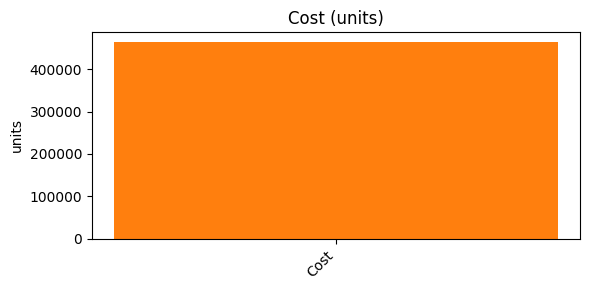

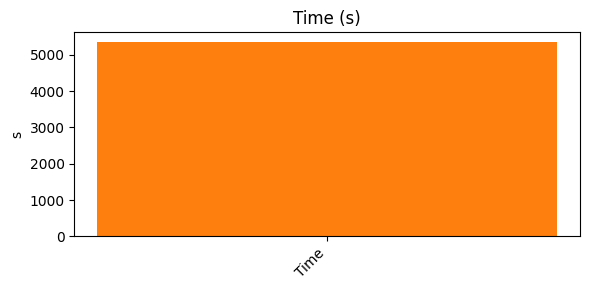

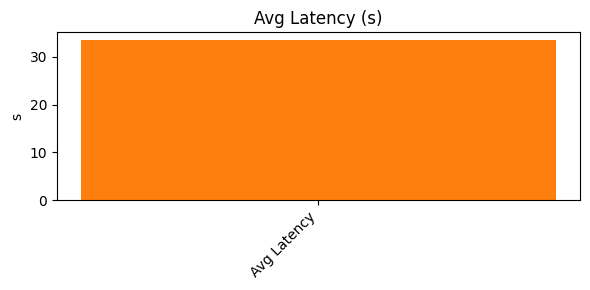

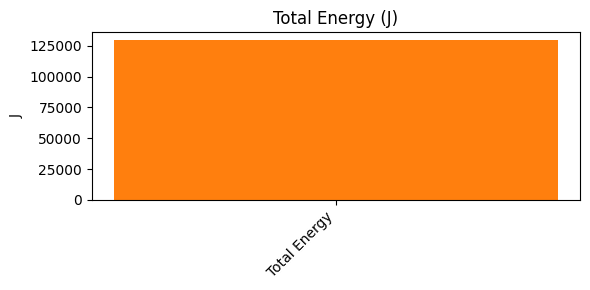

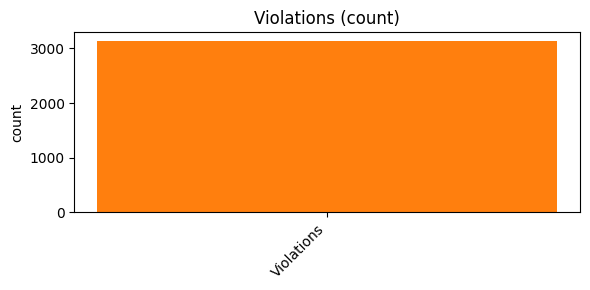

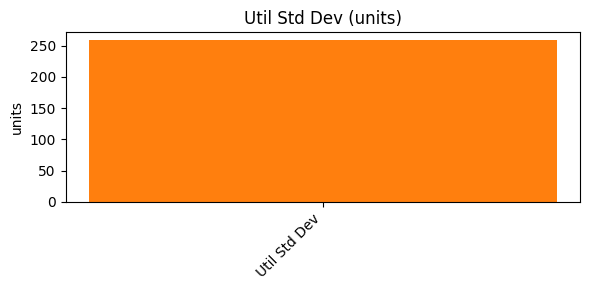

In [ ]:
# GA ONLY APPROACH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

TIERS = ['edge', 'fog', 'cloud']
CAPACITIES = {'edge': 2.0, 'fog': 10.0, 'cloud': 50.0}
LATENCY_PARAMS = {
    ('edge', 'edge'): (0, 0), ('edge', 'fog'): (0.02, 10), ('edge', 'cloud'): (0.1, 100),
    ('fog', 'edge'): (0.02, 10), ('fog', 'fog'): (0, 0), ('fog', 'cloud'): (0.05, 50),
    ('cloud', 'edge'): (0.1, 100), ('cloud', 'fog'): (0.05, 50), ('cloud', 'cloud'): (0, 0)
}
IDLE_POWER = {'edge': 10, 'fog': 50, 'cloud': 200}
PEAK_POWER = {'edge': 50, 'fog': 150, 'cloud': 600}
ALPHA, BETA = 1.0, 1.0

units = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': 'units'
}

def compute_latency(task, tier):
    comp = task['cpu_load_units'] / CAPACITIES[tier]
    rate, base = LATENCY_PARAMS[('edge', tier)]
    return comp + base + task['data_size_MB'] * rate

def compute_energy(u, tier):
    return IDLE_POWER[tier] + (PEAK_POWER[tier] - IDLE_POWER[tier]) * u

def compute_cost(chrom, df_sub):
    total_lat, util = 0.0, {t: 0.0 for t in TIERS}
    latencies = []
    for gene, (_, task) in zip(chrom, df_sub.iterrows()):
        tier = TIERS[gene]
        lt = compute_latency(task, tier)
        total_lat += lt
        latencies.append(lt)
        util[tier] += task['cpu_load_units']
    total_energy = sum(compute_energy(util[t] / CAPACITIES[t], t) for t in TIERS)
    violations = np.sum(np.array(latencies) > df_sub['deadline_s'].values[:len(latencies)])
    util_std = np.std(list(util.values()))
    return ALPHA * total_lat + BETA * total_energy, np.mean(latencies), total_energy, violations, util_std

def initialize_population(pop_size, n_tasks):
    return [np.random.randint(0, len(TIERS), size=n_tasks).tolist() for _ in range(pop_size)]

def tournament_selection(population, fitness, tournament_size=3):
    indices = np.random.choice(len(population), tournament_size, replace=False)
    best_idx = indices[np.argmin([fitness[i] for i in indices])]
    return population[best_idx]

def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def mutate(chrom, mutation_rate=0.1):
    chrom = chrom.copy()
    for i in range(len(chrom)):
        if np.random.rand() < mutation_rate:
            chrom[i] = np.random.randint(0, len(TIERS))
    return chrom

def genetic_algorithm(df, pop_size=50, generations=100, mutation_rate=0.1):
    n_tasks = len(df)
    population = initialize_population(pop_size, n_tasks)
    best_chrom, best_cost = None, float('inf')

    for gen in range(generations):
        fitness = [compute_cost(chrom, df)[0] for chrom in population]
        new_population = []

        for _ in range(pop_size // 2):
            parent1 = tournament_selection(population, fitness)
            parent2 = tournament_selection(population, fitness)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])

        population = new_population
        fitness = [compute_cost(chrom, df)[0] for chrom in population]
        best_idx = np.argmin(fitness)
        if fitness[best_idx] < best_cost:
            best_cost = fitness[best_idx]
            best_chrom = population[best_idx]
        print(f"Generation {gen + 1}/{generations}, Best Cost: {best_cost:.2f}")

    return best_chrom, best_cost

df = pd.read_csv('/content/clusterdata-2019/processed_google_cluster_tasks.csv')

t0 = time.time()
assign_ga, cost_ga = genetic_algorithm(df, pop_size=50, generations=100, mutation_rate=0.1)
time_ga = time.time() - t0

c_ga, avg_lat_ga, eng_ga, viol_ga, ustd_ga = compute_cost(assign_ga, df)
metrics_ga = {
    'Cost': float(c_ga),
    'Time': float(time_ga),
    'Avg Latency': float(avg_lat_ga),
    'Total Energy': float(eng_ga),
    'Violations': int(viol_ga),
    'Util Std Dev': float(ustd_ga)
}

print("Genetic Algorithm Metrics:")
for metric, value in metrics_ga.items():
    unit = units.get(metric, '')
    if isinstance(value, float):
        print(f"{metric}: {value:.2f} {unit}")
    else:
        print(f"{metric}: {value} {unit}")

for metric, value in metrics_ga.items():
    plt.figure(figsize=(6, 3))
    plt.bar([metric], [value], color='C1')
    unit = units.get(metric, '')
    plt.title(f"{metric} ({unit})")
    plt.ylabel(unit)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Iteration 0/1000, Best Cost: 502808.50, Temperature: 995.00
Iteration 100/1000, Best Cost: 502632.50, Temperature: 602.74
Iteration 200/1000, Best Cost: 502543.66, Temperature: 365.12
Iteration 300/1000, Best Cost: 502370.50, Temperature: 221.18
Iteration 400/1000, Best Cost: 501055.81, Temperature: 133.98
Iteration 500/1000, Best Cost: 500792.63, Temperature: 81.16
Iteration 600/1000, Best Cost: 499740.49, Temperature: 49.17
Iteration 700/1000, Best Cost: 499034.45, Temperature: 29.78
Iteration 800/1000, Best Cost: 496310.79, Temperature: 18.04
Iteration 900/1000, Best Cost: 494200.80, Temperature: 10.93
Simulated Annealing Metrics:
Cost: 492005.12 units
Time: 549.98 s
Avg Latency: 36.52 s
Total Energy: 126771.36 J
Violations: 3462 count
Util Std Dev: 58.00 units


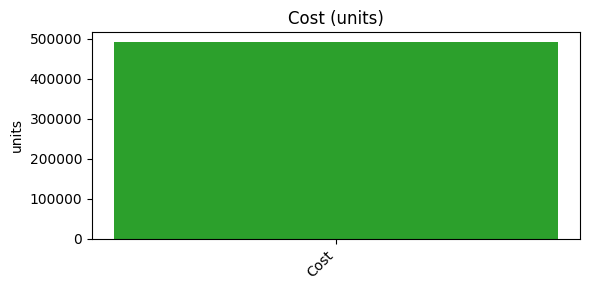

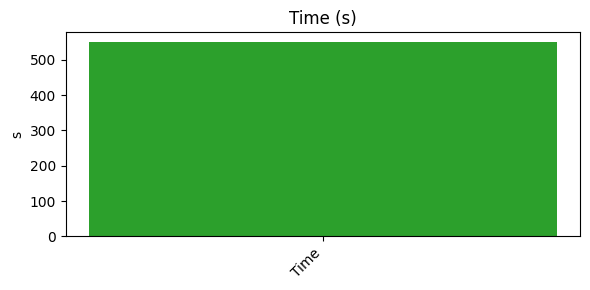

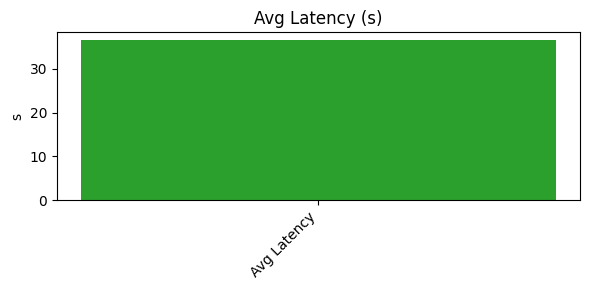

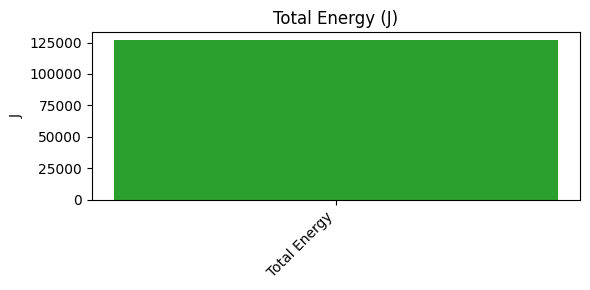

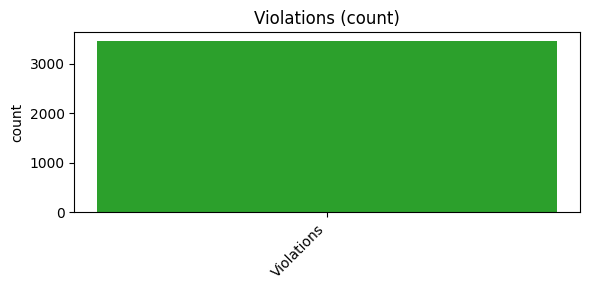

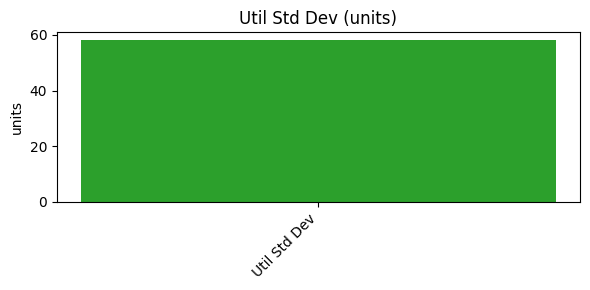

In [ ]:
# SA ONLY APPROACH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

TIERS = ['edge', 'fog', 'cloud']
CAPACITIES = {'edge': 2.0, 'fog': 10.0, 'cloud': 50.0}
LATENCY_PARAMS = {
    ('edge', 'edge'): (0, 0), ('edge', 'fog'): (0.02, 10), ('edge', 'cloud'): (0.1, 100),
    ('fog', 'edge'): (0.02, 10), ('fog', 'fog'): (0, 0), ('fog', 'cloud'): (0.05, 50),
    ('cloud', 'edge'): (0.1, 100), ('cloud', 'fog'): (0.05, 50), ('cloud', 'cloud'): (0, 0)
}
IDLE_POWER = {'edge': 10, 'fog': 50, 'cloud': 200}
PEAK_POWER = {'edge': 50, 'fog': 150, 'cloud': 600}
ALPHA, BETA = 1.0, 1.0

units = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': 'units'
}

def compute_latency(task, tier):
    comp = task['cpu_load_units'] / CAPACITIES[tier]
    rate, base = LATENCY_PARAMS[('edge', tier)]
    return comp + base + task['data_size_MB'] * rate

def compute_energy(u, tier):
    return IDLE_POWER[tier] + (PEAK_POWER[tier] - IDLE_POWER[tier]) * u

def compute_cost(chrom, df_sub):
    total_lat, util = 0.0, {t: 0.0 for t in TIERS}
    latencies = []
    for gene, (_, task) in zip(chrom, df_sub.iterrows()):
        tier = TIERS[gene]
        lt = compute_latency(task, tier)
        total_lat += lt
        latencies.append(lt)
        util[tier] += task['cpu_load_units']
    total_energy = sum(compute_energy(util[t] / CAPACITIES[t], t) for t in TIERS)
    violations = np.sum(np.array(latencies) > df_sub['deadline_s'].values[:len(latencies)])
    util_std = np.std(list(util.values()))
    return ALPHA * total_lat + BETA * total_energy, np.mean(latencies), total_energy, violations, util_std

def simulated_annealing(df, initial_temp=1000, cooling_rate=0.995, iterations=1000):
    n_tasks = len(df)
    current_chrom = np.random.randint(0, len(TIERS), size=n_tasks).tolist()
    current_cost, *_ = compute_cost(current_chrom, df)
    best_chrom, best_cost = current_chrom, current_cost
    temp = initial_temp

    for i in range(iterations):
        new_chrom = current_chrom.copy()
        idx = np.random.randint(0, n_tasks)
        new_chrom[idx] = np.random.randint(0, len(TIERS))
        new_cost, *_ = compute_cost(new_chrom, df)

        if new_cost < current_cost or np.random.rand() < np.exp((current_cost - new_cost) / temp):
            current_chrom, current_cost = new_chrom, new_cost

        if new_cost < best_cost:
            best_chrom, best_cost = new_chrom, new_cost

        temp *= cooling_rate
        if i % 100 == 0:
            print(f"Iteration {i}/{iterations}, Best Cost: {best_cost:.2f}, Temperature: {temp:.2f}")

    return best_chrom, best_cost

df = pd.read_csv('/content/clusterdata-2019/processed_google_cluster_tasks.csv')

t0 = time.time()
assign_sa, cost_sa = simulated_annealing(df, initial_temp=1000, cooling_rate=0.995, iterations=1000)
time_sa = time.time() - t0

c_sa, avg_lat_sa, eng_sa, viol_sa, ustd_sa = compute_cost(assign_sa, df)
metrics_sa = {
    'Cost': float(c_sa),
    'Time': float(time_sa),
    'Avg Latency': float(avg_lat_sa),
    'Total Energy': float(eng_sa),
    'Violations': int(viol_sa),
    'Util Std Dev': float(ustd_sa)
}

print("Simulated Annealing Metrics:")
for metric, value in metrics_sa.items():
    unit = units.get(metric, '')
    if isinstance(value, float):
        print(f"{metric}: {value:.2f} {unit}")
    else:
        print(f"{metric}: {value} {unit}")

for metric, value in metrics_sa.items():
    plt.figure(figsize=(6, 3))
    plt.bar([metric], [value], color='C2')
    unit = units.get(metric, '')
    plt.title(f"{metric} ({unit})")
    plt.ylabel(unit)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# HYBRID GA + SA APPROACH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool

TIERS = ['edge', 'fog', 'cloud']
CAPACITIES = {'edge': 2.0, 'fog': 10.0, 'cloud': 50.0}
LATENCY_PARAMS = {
    ('edge', 'edge'): (0, 0), ('edge', 'fog'): (0.02, 10), ('edge', 'cloud'): (0.1, 100),
    ('fog', 'edge'): (0.02, 10), ('fog', 'fog'): (0, 0), ('fog', 'cloud'): (0.05, 50),
    ('cloud', 'edge'): (0.1, 100), ('cloud', 'fog'): (0.05, 50), ('cloud', 'cloud'): (0, 0)
}
IDLE_POWER = {'edge': 10, 'fog': 50, 'cloud': 200}
PEAK_POWER = {'edge': 50, 'fog': 150, 'cloud': 600}
ALPHA, BETA = 1.0, 1.0

units = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': 'units'
}

def compute_cost(chrom, df_values):
    chrom = np.array(chrom)
    tiers = np.array(TIERS)[chrom]

    comp = df_values['cpu_load_units'] / np.array([CAPACITIES[t] for t in tiers])
    rates = np.array([LATENCY_PARAMS[('edge', t)][0] for t in tiers])
    bases = np.array([LATENCY_PARAMS[('edge', t)][1] for t in tiers])
    latencies = comp + bases + df_values['data_size_MB'] * rates
    total_lat = np.sum(latencies)

    util = np.zeros(len(TIERS))
    for i, t in enumerate(TIERS):
        util[i] = np.sum(df_values['cpu_load_units'][tiers == t])

    total_energy = np.sum([compute_energy(util[i] / CAPACITIES[t], t) for i, t in enumerate(TIERS)])
    violations = np.sum(latencies > df_values['deadline_s'])
    util_std = np.std(util)

    return ALPHA * total_lat + BETA * total_energy, np.mean(latencies), total_energy, violations, util_std

def compute_energy(u, tier):
    return IDLE_POWER[tier] + (PEAK_POWER[tier] - IDLE_POWER[tier]) * u

def compute_cost_wrapper(args):
    chrom, df_values = args
    return compute_cost(chrom, df_values)[0]

def initialize_population(pop_size, n_tasks):
    return [np.random.randint(0, len(TIERS), size=n_tasks).tolist() for _ in range(pop_size)]

def tournament_selection(population, fitness, tournament_size=3):
    indices = np.random.choice(len(population), tournament_size, replace=False)
    best_idx = indices[np.argmin([fitness[i] for i in indices])]
    return population[best_idx]

def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def mutate(chrom, mutation_rate=0.1):
    chrom = chrom.copy()
    for i in range(len(chrom)):
        if np.random.rand() < mutation_rate:
            chrom[i] = np.random.randint(0, len(TIERS))
    return chrom

def simulated_annealing_for_hybrid(chrom, df_values, initial_temp=100, cooling_rate=0.99, iterations=30):
    current_chrom = chrom.copy()
    current_cost, *_ = compute_cost(current_chrom, df_values)
    best_chrom, best_cost = current_chrom, current_cost
    temp = initial_temp

    for i in range(iterations):
        new_chrom = current_chrom.copy()
        idx = np.random.randint(0, len(new_chrom))
        new_chrom[idx] = np.random.randint(0, len(TIERS))
        new_cost, *_ = compute_cost(new_chrom, df_values)

        if new_cost < current_cost or np.random.rand() < np.exp((current_cost - new_cost) / temp):
            current_chrom, current_cost = new_chrom, new_cost

        if new_cost < best_cost:
            best_chrom, best_cost = new_chrom, new_cost

        temp *= cooling_rate

    return best_chrom, best_cost

def hybrid_ga_sa(df_values, pop_size=30, generations=100, mutation_rate=0.1, elitism_count=2):
    n_tasks = len(df_values['cpu_load_units'])
    population = initialize_population(pop_size, n_tasks)
    best_chrom, best_cost = None, float('inf')

    with Pool(processes=2) as pool:
        for gen in range(generations):
            t_gen_start = time.time()
            fitness = pool.map(compute_cost_wrapper, [(chrom, df_values) for chrom in population])
            # Elitism: Keep the top elitism_count chromosomes
            sorted_indices = np.argsort(fitness)
            elites = [population[i] for i in sorted_indices[:elitism_count]]
            new_population = elites.copy()

            while len(new_population) < pop_size:
                parent1 = tournament_selection(population, fitness)
                parent2 = tournament_selection(population, fitness)
                child1, child2 = crossover(parent1, parent2)
                child1 = mutate(child1, mutation_rate)
                child2 = mutate(child2, mutation_rate)
                child1, cost1 = simulated_annealing_for_hybrid(child1, df_values)
                child2, cost2 = simulated_annealing_for_hybrid(child2, df_values)
                new_population.extend([child1, child2])

            population = new_population[:pop_size]  # Ensure population size is maintained
            fitness = pool.map(compute_cost_wrapper, [(chrom, df_values) for chrom in population])
            best_idx = np.argmin(fitness)
            if fitness[best_idx] < best_cost:
                best_cost = fitness[best_idx]
                best_chrom = population[best_idx]
            print(f"Generation {gen + 1}/{generations}, Best Cost: {best_cost:.2f}, Time: {time.time() - t_gen_start:.2f} s")

    return best_chrom, best_cost

# Load and preprocess data
df = pd.read_csv('/content/clusterdata-2019/processed_google_cluster_tasks.csv')
df_values = {
    'cpu_load_units': df['cpu_load_units'].values,
    'data_size_MB': df['data_size_MB'].values,
    'deadline_s': df['deadline_s'].values
}

# Set random seed for reproducibility
np.random.seed(42)

t0 = time.time()
assign_hybrid, cost_hybrid = hybrid_ga_sa(df_values, pop_size=30, generations=100, mutation_rate=0.1, elitism_count=2)
time_hybrid = time.time() - t0

c_hybrid, avg_lat_hybrid, eng_hybrid, viol_hybrid, ustd_hybrid = compute_cost(assign_hybrid, df_values)
metrics_hybrid = {
    'Cost': float(c_hybrid),
    'Time': float(time_hybrid),
    'Avg Latency': float(avg_lat_hybrid),
    'Total Energy': float(eng_hybrid),
    'Violations': int(viol_hybrid),
    'Util Std Dev': float(ustd_hybrid)
}

print("Hybrid GA+SA Metrics:")
for metric, value in metrics_hybrid.items():
    unit = units.get(metric, '')
    if isinstance(value, float):
        print(f"{metric}: {value:.2f} {unit}")
    else:
        print(f"{metric}: {value} {unit}")

for metric, value in metrics_hybrid.items():
    plt.figure(figsize=(6, 3))
    plt.bar([metric], [value], color='C3')
    unit = units.get(metric, '')
    plt.title(f"{metric} ({unit})")
    plt.ylabel(unit)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/clusterdata-2019/processed_google_cluster_tasks.csv'

In [ ]:
import pandas as pd

# File path to save the results
results_file = '/content/clusterdata-2019/scheduling_results.txt'

# Function to append text to the file
def append_to_file(text, file_path, section_title=""):
    with open(file_path, 'a') as f:
        if section_title:
            f.write(f"\n{'=' * 50}\n{section_title}\n{'=' * 50}\n")
        f.write(text + '\n')

# Clear the file if it exists (start fresh)
with open(results_file, 'w') as f:
    f.write("Scheduling Results - 2019 Google Cluster Workload Trace\n")
    f.write(f"Generated on: {pd.Timestamp.now()}\n")

# --- Preprocessing Results ---
# Capture preprocessing output as a string
preprocessing_output = (
    "Preprocessed Dataset Statistics:\n" +
    df.describe().to_string() + "\n\n" +
    "First 5 rows of preprocessed dataset:\n" +
    df.head().to_string()
)
append_to_file(preprocessing_output, results_file, "Preprocessing Results")

# --- Brute Force Results ---
brute_force_output = "Brute Force (Batched) Metrics:\n"
for metric, value in metrics_bf.items():
    unit = units.get(metric, '')
    if isinstance(value, float):
        brute_force_output += f"{metric}: {value:.2f} {unit}\n"
    else:
        brute_force_output += f"{metric}: {value} {unit}\n"
append_to_file(brute_force_output, results_file, "Brute Force Results")

# --- Genetic Algorithm Results ---
ga_output = "Genetic Algorithm Metrics:\n"
for metric, value in metrics_ga.items():
    unit = units.get(metric, '')
    if isinstance(value, float):
        ga_output += f"{metric}: {value:.2f} {unit}\n"
    else:
        ga_output += f"{metric}: {value} {unit}\n"
append_to_file(ga_output, results_file, "Genetic Algorithm Results")

# --- Simulated Annealing Results ---
sa_output = "Simulated Annealing Metrics:\n"
for metric, value in metrics_sa.items():
    unit = units.get(metric, '')
    if isinstance(value, float):
        sa_output += f"{metric}: {value:.2f} {unit}\n"
    else:
        sa_output += f"{metric}: {value} {unit}\n"
append_to_file(sa_output, results_file, "Simulated Annealing Results")

# --- Hybrid GA+SA Results ---
hybrid_output = "Hybrid GA+SA Metrics:\n"
for metric, value in metrics_hybrid.items():
    unit = units.get(metric, '')
    if isinstance(value, float):
        hybrid_output += f"{metric}: {value:.2f} {unit}\n"
    else:
        hybrid_output += f"{metric}: {value} {unit}\n"
append_to_file(hybrid_output, results_file, "Hybrid GA+SA Results")

# Confirmation message
print(f"Results have been saved to {results_file}")

Results have been saved to /content/clusterdata-2019/scheduling_results.txt


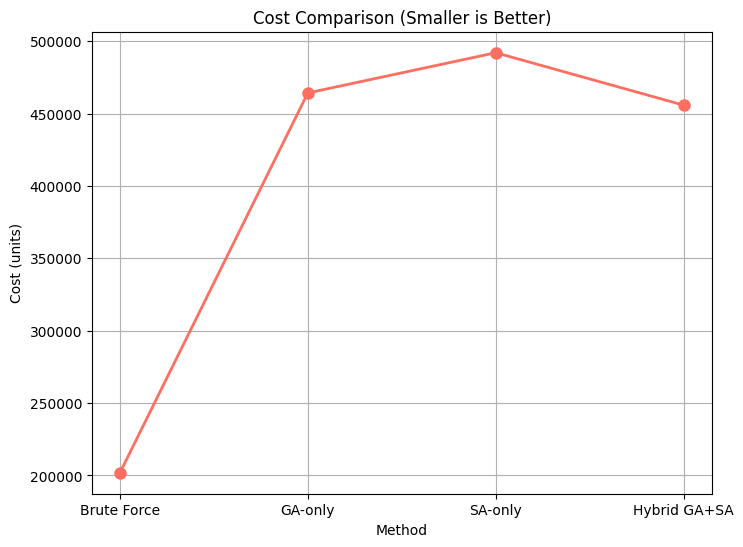

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your scheduling results
metrics = {
    'Cost': float(455776.14),  # Using the hybrid GA+SA result for reference
    'Time': float(1746.51),
    'Avg Latency': float(32.55),
    'Total Energy': float(130323.17),
    'Violations': int(3046),
    'Util Std Dev': float(325.40)
}
units = {
    'Cost': 'units',
    'Time': 's',
    'Avg Latency': 's',
    'Total Energy': 'J',
    'Violations': 'count',
    'Util Std Dev': 'units'
}
methods = ['Brute Force', 'GA-only', 'SA-only', 'Hybrid GA+SA']
values = {
    'Cost': [201858.27, 464218.35, 492005.12, 455776.14],
    'Time': [9497.34, 5350.49, 549.98, 1746.51],
    'Avg Latency': [9.33, 33.47, 36.52, 32.55],
    'Total Energy': [108553.26, 129565.49, 126771.36, 130323.17],
    'Violations': [460, 3138, 3462, 3046],
    'Util Std Dev': [4149.85, 258.28, 58.00, 325.40]
}

# Colors suitable for dark and light themes
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9']  # Coral, Purple, Olive Green, Light Pink

# Tag for interpretation
tag = "(Smaller is Better)"  # Define the tag here to avoid NameError

# 1. Cost - Line Plot (equivalent to Line Chart)
plt.figure(figsize=(8, 6))
plt.plot(methods, values['Cost'], marker='o', color='#FF6F61', linestyle='-', linewidth=2, markersize=8)
plt.title(f'Cost Comparison {tag}')
plt.xlabel('Method')
plt.ylabel(f"Cost ({units['Cost']})")
plt.grid(True)
plt.savefig('cost_line.png')
plt.show()



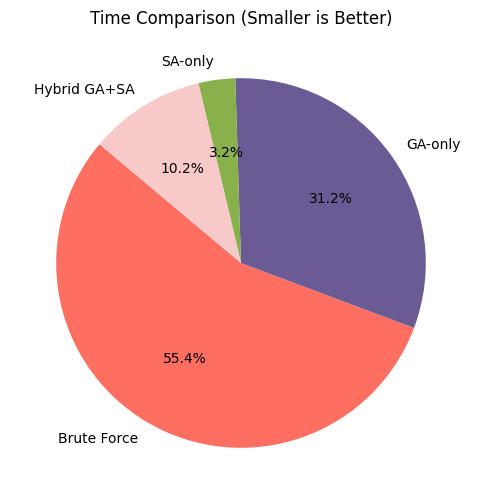

In [ ]:
# 2. Time
plt.figure(figsize=(8, 6))
plt.pie(values['Time'], labels=methods, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title(f'Time Comparison {tag}')
plt.savefig('time_pie.png')
plt.show()

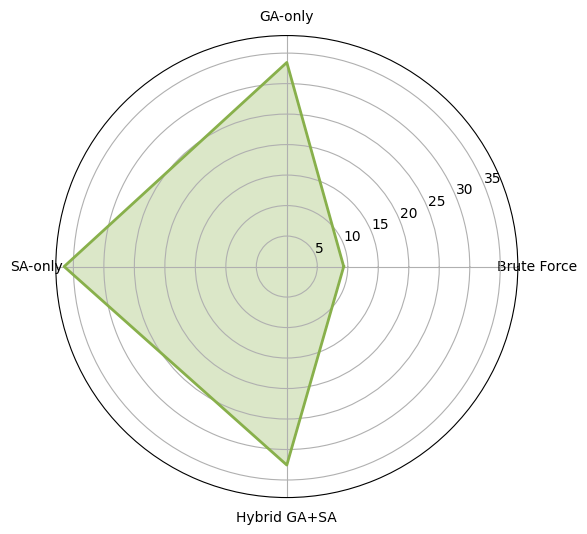

In [ ]:
# 3. Avg Latency
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)
theta = np.linspace(0, 2 * np.pi, len(methods), endpoint=False)
radii = values['Avg Latency']
theta = np.append(theta, theta[0])  # Close the loop
radii = np.append(radii, radii[0])
ax.plot(theta, radii, color='#88B04B', linewidth=2)
ax.fill(theta, radii, color='#88B04B', alpha=0.3)
ax.set_xticks(theta[:-1])
ax.set_xticklabels(methods)
#ax.set_title(f'Avg Latency Comparison (Radar) {tag}', loc='left', pad=20, fontsize=12, va='center')
plt.savefig('latency_radar.png')
plt.show()

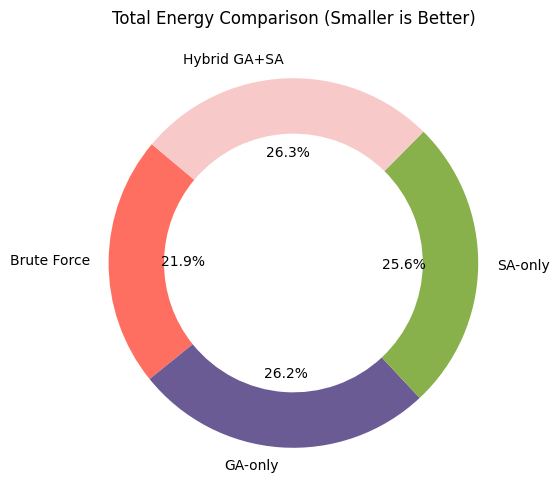

In [ ]:
# 4. Total Energy
plt.figure(figsize=(8, 6))
plt.pie(values['Total Energy'], labels=methods, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title(f'Total Energy Comparison {tag}')
plt.savefig('energy_donut.png')
plt.show()

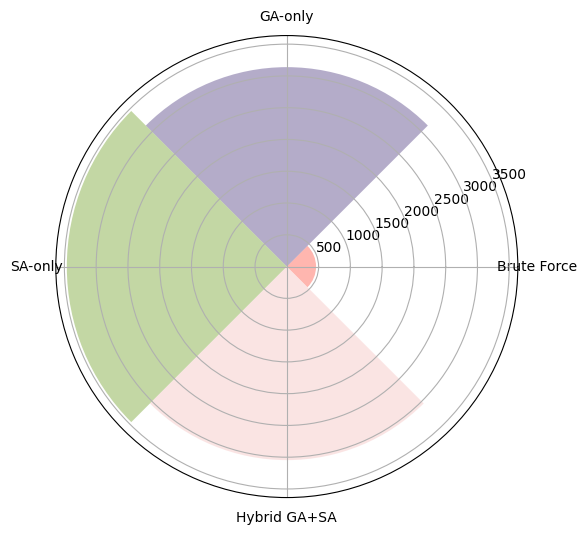

In [ ]:
# 5. Violations
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)
theta = np.linspace(0, 2 * np.pi, len(methods), endpoint=False)
radii = values['Violations']
width = 2 * np.pi / len(methods)
bars = ax.bar(theta, radii, width=width, color=[f"{c}80" for c in colors], alpha=0.5)
ax.set_xticks(theta)
ax.set_xticklabels(methods)
#ax.set_title(f'Violations Comparison {tag}')
plt.savefig('violations_polararea.png')
plt.show()

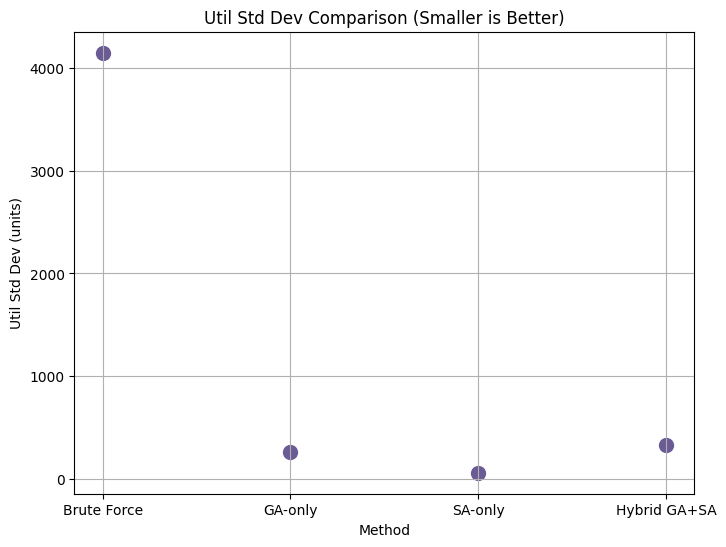

In [ ]:
# 6. Util Std Dev
plt.figure(figsize=(8, 6))
x = np.arange(1, len(methods) + 1)
plt.scatter(x, values['Util Std Dev'], color='#6B5B95', s=100)
plt.xticks(x, methods)
plt.title(f'Util Std Dev Comparison {tag}')
plt.xlabel('Method')
plt.ylabel(f"Util Std Dev ({units['Util Std Dev']})")
plt.grid(True)
plt.savefig('utilstd_scatter.png')
plt.show()